In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import datetime

In [2]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from yellowbrick.target import ClassBalance
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport

In [3]:
# Load the data
file_path = Path('Resources/financials_and_sentiments.csv')
df = pd.read_csv(file_path)

In [4]:
df.head()

,Ticker,Date,Pos,Neu,Neg,Normalized,Close,Returns,12-day Rolling,5-day Rolling,3-day Rolling,12-day Rolling Std,5-day Rolling Std,3-day Rolling Std,difference 1-day,difference 3-days,direction 1-day,direction 3-days
0,A,2019-08-14,0.101,0.884,0.014,1,65.59,-0.030308,-0.005657,-0.006860,-0.014811,0.020223,0.024598,0.025959,-2.05,-3.05,0,0
1,AAL,2019-10-24,0.133,0.847,0.020,1,29.41,0.039590,0.009595,0.010526,0.009358,0.015567,0.019245,0.027056,1.12,0.79,1,1
2,AAP,2019-11-12,0.121,0.863,0.015,1,156.14,-0.075110,-0.004594,-0.014186,-0.025911,0.024032,0.035081,0.043719,-12.68,-13.14,0,0
3,AAPL,2019-10-30,0.130,0.851,0.018,1,243.26,-0.000123,0.002627,0.000145,-0.004411,0.010672,0.014049,0.016983,-0.03,-3.32,0,0
4,ABBV,2019-11-01,0.118,0.862,0.020,1,81.75,0.027656,0.007551,0.013349,0.013813,0.011847,0.012865,0.014565,2.20,3.28,1,1


In [5]:
#Create new field for month of earnings call"
df['month'] = pd.DatetimeIndex(df['Date']).month

In [6]:
#Dropping columns not needed for model and NAs
columns_to_drop = ["Ticker","Date","Normalized","Close","Returns",
                   "5-day Rolling","3-day Rolling","5-day Rolling Std","3-day Rolling Std",
                   "difference 1-day","difference 3-days","direction 1-day"]
df_12day_post3days = df.drop(columns=columns_to_drop)
df_12day_post3days.dropna(inplace=True)

In [7]:
df_12day_post3days.head()

,Pos,Neu,Neg,12-day Rolling,12-day Rolling Std,direction 3-days,month
0,0.101,0.884,0.014,-0.005657,0.020223,0,8
1,0.133,0.847,0.020,0.009595,0.015567,1,10
2,0.121,0.863,0.015,-0.004594,0.024032,0,11
3,0.130,0.851,0.018,0.002627,0.010672,0,10
4,0.118,0.862,0.020,0.007551,0.011847,1,11


# Split training and test

In [8]:
# Create our features
X = df_12day_post3days.drop(columns="direction 3-days")

# Create our target
y = df_12day_post3days["direction 3-days"]

In [9]:
X.describe()

,Pos,Neu,Neg,12-day Rolling,12-day Rolling Std,month
count,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000
mean,0.122707,0.858085,0.019189,0.002394,0.017249,10.082949
std,0.019524,0.019271,0.006994,0.005286,0.010080,0.701391
min,0.073000,0.776000,0.005000,-0.019061,0.004357,7.000000
25%,0.110000,0.846000,0.014000,-0.000612,0.010848,10.000000
50%,0.122500,0.859000,0.018000,0.002185,0.015144,10.000000
75%,0.134000,0.871000,0.022000,0.005465,0.020054,10.000000
max,0.204000,0.910000,0.049000,0.024624,0.095017,11.000000


In [10]:
# Check the balance of our target values
y.value_counts()

1    257
0    177
Name: direction 3-days, dtype: int64

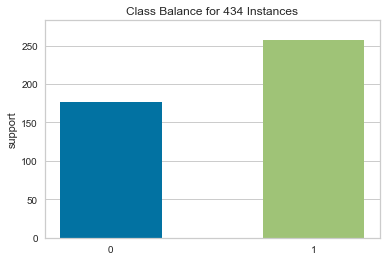

In [11]:
# Visualize distribution of y
from yellowbrick.target import ClassBalance

viz = ClassBalance()
viz.fit(y)
viz.show()

In [12]:
# Create X_train, X_test, y_train, y_test
# YOUR CODE HERE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [13]:
print (f"Train data: {Counter(y_train)}"), print (f"Test Data: {Counter(y_test)}")

Train data: Counter({1: 186, 0: 139})
Test Data: Counter({1: 71, 0: 38})


(None, None)

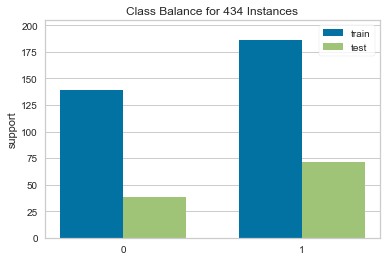

In [14]:
# Visualize train and test y
viz = ClassBalance()

viz.fit(y_train,y_test)
viz.show()

## Naive Random Oversampling

In [15]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print (f"Train data: {Counter(y_resampled)}"), print (f"Test Data: {Counter(y_test)}")

Train data: Counter({1: 186, 0: 186})
Test Data: Counter({1: 71, 0: 38})


(None, None)

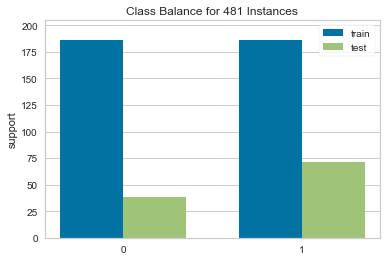

In [16]:
# Visualize resampled train and test y
viz = ClassBalance()
viz.fit(y_resampled,y_test)
viz.show()

In [17]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression

model_ROS = LogisticRegression(random_state=1)
model_ROS.fit(X_resampled, y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
# Predict using out-of-sample data
y_pred = model_ROS.predict(X_test)

In [19]:
# Calculated the balanced accuracy score
# YOUR CODE HERE
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.4570051890289103

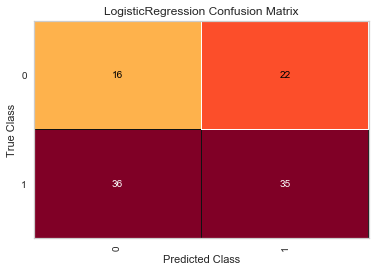

In [20]:
# Visualize confusion matrix
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(model_ROS)
cm.fit(X_resampled, y_resampled)
cm.score(X_test, y_test)
cm.show()

In [21]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.31      0.42      0.49      0.36      0.46      0.21        38
          1       0.61      0.49      0.42      0.55      0.46      0.21        71

avg / total       0.51      0.47      0.45      0.48      0.46      0.21       109



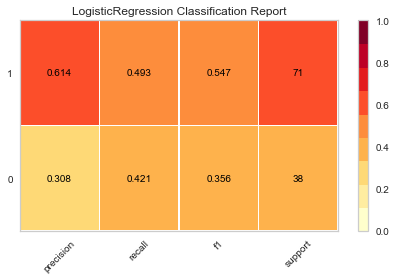

In [22]:
# Visualize imbalanced classification report
from yellowbrick.classifier import ClassificationReport

viz = ClassificationReport(model_ROS, support=True)
viz.fit(X_resampled, y_resampled)
viz.score(X_test, y_test)
viz.show()

## SMOTE Oversampling

In [23]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE(random_state=1, ratio=1.0).fit_resample(
    X_train, y_train
)

Counter(y_resampled),  Counter(y_test)

(Counter({1: 186, 0: 186}), Counter({1: 71, 0: 38}))

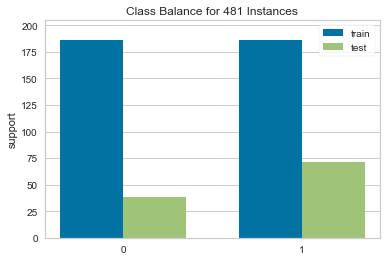

In [24]:
# Visualize resampled train and test y
viz = ClassBalance()

viz.fit(y_resampled,y_test)
viz.show()

In [25]:
# Train the Logistic Regression model using the resampled data
model_SMOTE = LogisticRegression(random_state=1)
model_SMOTE.fit(X_resampled, y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
# Predict using out-of-sample data
y_pred = model_SMOTE.predict(X_test)

In [27]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.43773165307635287

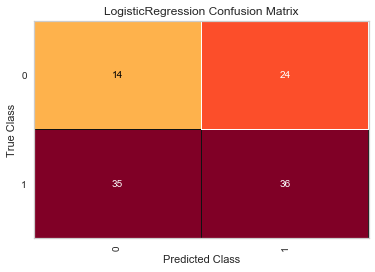

In [28]:
# Visualize confusion matrix
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(model_SMOTE)
cm.fit(X_resampled, y_resampled)
cm.score(X_test, y_test)
cm.show()

In [29]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.29      0.37      0.51      0.32      0.43      0.18        38
          1       0.60      0.51      0.37      0.55      0.43      0.19        71

avg / total       0.49      0.46      0.42      0.47      0.43      0.19       109



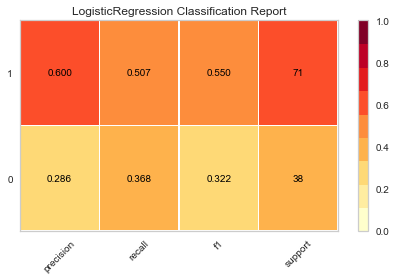

In [30]:
# Visualize imbalanced classification report 
viz = ClassificationReport(model_SMOTE, support=True)
viz.fit(X_resampled, y_resampled)
viz.score(X_test, y_test)
viz.show()

## Undersampling

In [31]:
# Resample the data using the ClusterCentroids resampler
# YOUR CODE HERE
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

Counter(y_resampled), Counter(y_test)

(Counter({0: 139, 1: 139}), Counter({1: 71, 0: 38}))

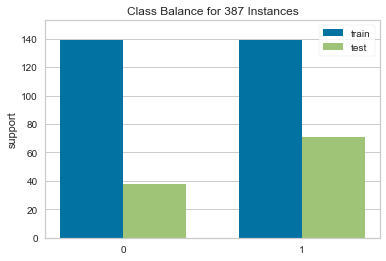

In [32]:
# Visualize resampled train and test y
viz = ClassBalance()

viz.fit(y_resampled,y_test)
viz.show()

In [33]:
# Train the Logistic Regression model using the resampled data
model_CC = LogisticRegression(random_state=1)
model_CC.fit(X_resampled, y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
# Predict using out-of-sample data
y_pred = model_CC.predict(X_test)

In [35]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.4551519644180875

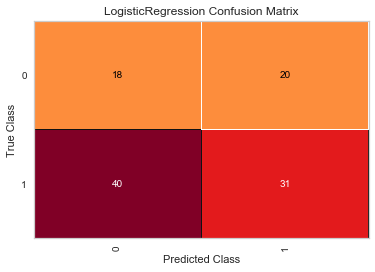

In [36]:
# Visualize confusion matrix
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(model_CC)
cm.fit(X_resampled, y_resampled)
cm.score(X_test, y_test)
cm.show()

In [37]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.31      0.47      0.44      0.38      0.45      0.21        38
          1       0.61      0.44      0.47      0.51      0.45      0.21        71

avg / total       0.50      0.45      0.46      0.46      0.45      0.21       109



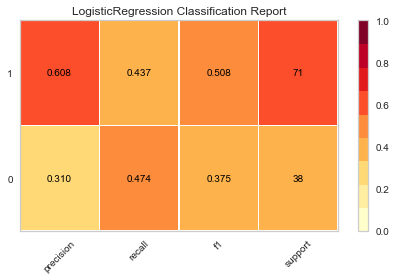

In [38]:
# Visualize imbalanced classification report
viz = ClassificationReport(model_CC, support=True)
viz.fit(X_resampled, y_resampled)
viz.score(X_test, y_test)
viz.show()

## Combination (Over and Under) Sampling

In [39]:
# Resample the training data with SMOTEENN
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=1)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
print (f"Re-sampled train data: {Counter(y_resampled)}"), print (f"Test data: {Counter(y_test)}")

Re-sampled train data: Counter({0: 68, 1: 54})
Test data: Counter({1: 71, 0: 38})


(None, None)

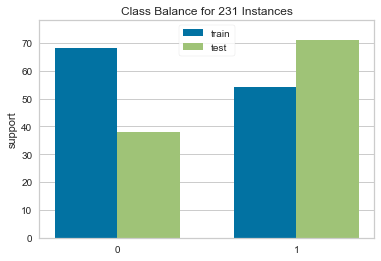

In [40]:
# Visualize resampled train and test y
viz = ClassBalance()

viz.fit(y_resampled,y_test)
viz.show()

In [41]:
# Train the Logistic Regression model using the resampled data
model_SMOTEEN = LogisticRegression(random_state=1)
model_SMOTEEN.fit(X_resampled, y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
# Predict using out-of-sample data
y_pred = model_SMOTEEN.predict(X_test)

In [43]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.48776871756856927

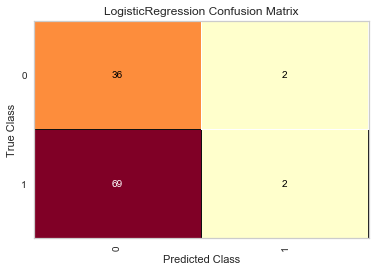

In [44]:
# Visualize confusion matrix
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(model_SMOTEEN)
cm.fit(X_resampled, y_resampled)
cm.score(X_test, y_test)
cm.show()

In [45]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.34      0.95      0.03      0.50      0.16      0.03        38
          1       0.50      0.03      0.95      0.05      0.16      0.02        71

avg / total       0.45      0.35      0.63      0.21      0.16      0.03       109



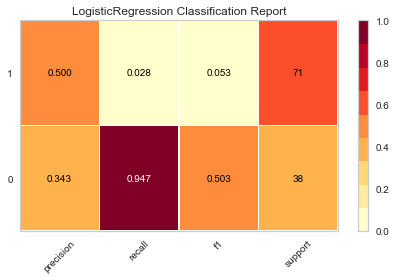

In [46]:
# Visualize imbalanced classification report 
viz = ClassificationReport(model_SMOTEEN, support=True)
viz.fit(X_resampled, y_resampled)
viz.score(X_test, y_test)
viz.show()